COVID 19 Data analysis and ML model

By :Konzolo iyke






---




# **Importations**

In [3]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder

# **Loading datasets**

In [4]:
country_wise_latest = pd.read_csv('/content/drive/MyDrive/archive/country_wise_latest.csv')

covid_19_clean_complete = pd.read_csv('/content/drive/MyDrive/archive/covid_19_clean_complete.csv')

day_wise = pd.read_csv('/content/drive/MyDrive/archive/day_wise.csv')

full_grouped = pd.read_csv('/content/drive/MyDrive/archive/full_grouped.csv')

usa_county_wise = pd.read_csv('/content/drive/MyDrive/archive/usa_county_wise.csv')

worldometer_data = pd.read_csv('/content/drive/MyDrive/archive/worldometer_data.csv')

In [1]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/archive')

Mounted at /content/drive






---




#1. **Preprocessing**

# **Check for missing values**

In [5]:
print("missing values in country_wise_latest:")

print(country_wise_latest.isnull().sum(), "\n")



print("missing values in covid_19_clean_complete:")

print(covid_19_clean_complete.isnull().sum(), "\n")



print("missing values in day_wise:")

print(day_wise.isnull().sum(), "\n")



print("missing values in full_grouped:")

print(full_grouped.isnull().sum(), "\n")



print("missing values in usa_county_wise:")

print(usa_county_wise.isnull().sum(), "\n")



print("missing values in worldometer_data:")

print(worldometer_data.isnull().sum(), "\n")

missing values in country_wise_latest:
Country/Region            0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
New cases                 0
New deaths                0
New recovered             0
Deaths / 100 Cases        0
Recovered / 100 Cases     0
Deaths / 100 Recovered    0
Confirmed last week       0
1 week change             0
1 week % increase         0
WHO Region                0
dtype: int64 

missing values in covid_19_clean_complete:
Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64 

missing values in day_wise:
Date                      0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
New cases                 0
New deaths                0
New 

# Data Cleaning and Imputation Process

This section of the notebook performs data preprocessing and missing value imputation on three COVID-19 datasets: `covid_19_clean_complete`, `usa_county_wise`, and `worldometer_data`. The goal is to handle missing values through different imputation strategies, including the use of KNN imputation, forward filling, and replacing with the mode or median.



### 1. `covid_19_clean_complete`:

- **Province/State**: Missing values are imputed with the mode of each `Country/Region`.

- **Confirmed, Deaths, Recovered, Active**: Missing values are imputed using KNN imputation (with 5 neighbors).

- **WHO Region**: Missing values are forward-filled based on `Country/Region`.



### 2. `usa_county_wise`:

- **Admin2**: Missing values are imputed with the mode of each `Province_State`.

- **FIPS**: Rows with missing `FIPS` values are dropped, as they are critical for identification.



### 3. `worldometer_data`:

- **Label Encoding**: Categorical columns `Country/Region` and `WHO Region` are encoded using `LabelEncoder`.

- **Continent, Population**: Missing values are imputed using KNN imputation (based on encoded values of `Country/Region` and `WHO Region`).

- **NewCases, NewDeaths, TotalRecovered**: Missing values are imputed using KNN imputation.

- **Serious,Critical**: Missing values are filled with the median for each `Country/Region`.

- **TotalDeaths**: Missing values are forward-filled.

- **ActiveCases**: Missing values are computed as the difference between `TotalCases`, `TotalDeaths`, and `TotalRecovered`.

- **NewRecovered, Serious,Critical, WHO Region**: Rows with missing values in these columns are dropped.

- **Tot Cases/1M pop, Deaths/1M pop**: Missing values are imputed using KNN imputation.

- **TotalTests, Tests/1M pop**: Missing values are forward-filled.


In [6]:
# 1. covid_19_clean_complete



covid_19_clean_complete['Province/State'] = covid_19_clean_complete.groupby('Country/Region')['Province/State'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

imputer = KNNImputer(n_neighbors=5)

covid_19_clean_complete[['Confirmed', 'Deaths', 'Recovered', 'Active']] = imputer.fit_transform(covid_19_clean_complete[['Confirmed', 'Deaths', 'Recovered', 'Active']])

covid_19_clean_complete['WHO Region'] = covid_19_clean_complete.groupby('Country/Region')['WHO Region'].transform(lambda x: x.fillna(method='ffill'))



# 2. usa_county_wise



usa_county_wise['Admin2'] = usa_county_wise.groupby('Province_State')['Admin2'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

usa_county_wise.dropna(subset=['FIPS'], inplace=True)



# 3. worldometer_data

label_encoder_country = LabelEncoder()

label_encoder_region = LabelEncoder()



worldometer_data['Country/Region_encoded'] = label_encoder_country.fit_transform(worldometer_data['Country/Region'].astype(str))

worldometer_data['WHO Region_encoded'] = label_encoder_region.fit_transform(worldometer_data['WHO Region'].astype(str))



continent_columns = ['Country/Region_encoded', 'WHO Region_encoded']

imputer = KNNImputer(n_neighbors=5)



worldometer_data['Continent'] = imputer.fit_transform(worldometer_data[continent_columns])[:, 0]

worldometer_data['Population'] = imputer.fit_transform(worldometer_data[['Country/Region_encoded', 'Continent']])[:, 0]

worldometer_data[['NewCases', 'NewDeaths', 'TotalRecovered']] = imputer.fit_transform(worldometer_data[['NewCases', 'NewDeaths', 'TotalRecovered']])

worldometer_data['Serious,Critical'] = worldometer_data.groupby('Country/Region')['Serious,Critical'].transform(lambda x: x.fillna(x.median() if not x.median() is None else 0))

worldometer_data['TotalDeaths'] = worldometer_data['TotalDeaths'].fillna(method='ffill')

worldometer_data['Continent'] = label_encoder_country.inverse_transform(worldometer_data['Continent'].astype(int))

worldometer_data['ActiveCases'] = worldometer_data['ActiveCases'].fillna(worldometer_data['TotalCases'] - worldometer_data['TotalDeaths'] - worldometer_data['TotalRecovered'])

worldometer_data = worldometer_data.dropna(subset=['NewRecovered', 'Serious,Critical', 'WHO Region'])

worldometer_data[['Tot Cases/1M pop', 'Deaths/1M pop']] = imputer.fit_transform(worldometer_data[['Tot Cases/1M pop', 'Deaths/1M pop']])

worldometer_data['TotalTests'] = worldometer_data['TotalTests'].fillna(method='ffill')

worldometer_data['Tests/1M pop'] = worldometer_data['Tests/1M pop'].fillna(method='ffill')



print("covid_19_clean_complete missing values after imputation: \n", covid_19_clean_complete.isnull().sum())

print("usa_county_wise missing values after imputation: \n", usa_county_wise.isnull().sum())

print("worldometer_data missing values after imputation: \n", worldometer_data.isnull().sum())

<ipython-input-6-f9cb4854061d>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  covid_19_clean_complete['WHO Region'] = covid_19_clean_complete.groupby('Country/Region')['WHO Region'].transform(lambda x: x.fillna(method='ffill'))
<ipython-input-6-f9cb4854061d>:53: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  worldometer_data['TotalDeaths'] = worldometer_data['TotalDeaths'].fillna(method='ffill')
<ipython-input-6-f9cb4854061d>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worldometer_data[['Tot Cases/1M pop', 'Deaths/1M pop']] = imputer.fit_transform(worldometer_data

covid_19_clean_complete missing values after imputation: 
 Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
WHO Region        0
dtype: int64
usa_county_wise missing values after imputation: 
 UID               0
iso2              0
iso3              0
code3             0
FIPS              0
Admin2            0
Province_State    0
Country_Region    0
Lat               0
Long_             0
Combined_Key      0
Date              0
Confirmed         0
Deaths            0
dtype: int64
worldometer_data missing values after imputation: 
 Country/Region            0
Continent                 0
Population                0
TotalCases                0
NewCases                  0
TotalDeaths               0
NewDeaths                 0
TotalRecovered            0
NewRecovered              0
ActiveCases               0
Serious,Critical          0
Tot Cases/1M pop        

# **Understanding the columns and data types**

In [7]:
print("data types in country_wise_latest:")

print(country_wise_latest.dtypes, "\n")



print("data types in covid_19_clean_complete:")

print(covid_19_clean_complete.dtypes, "\n")



print("data types in day_wise:")

print(day_wise.dtypes, "\n")



print("data types in full_grouped:")

print(full_grouped.dtypes, "\n")



print("data types in usa_county_wise:")

print(usa_county_wise.dtypes, "\n")



print("data types in worldometer_data:")

print(worldometer_data.dtypes, "\n")

data types in country_wise_latest:
Country/Region             object
Confirmed                   int64
Deaths                      int64
Recovered                   int64
Active                      int64
New cases                   int64
New deaths                  int64
New recovered               int64
Deaths / 100 Cases        float64
Recovered / 100 Cases     float64
Deaths / 100 Recovered    float64
Confirmed last week         int64
1 week change               int64
1 week % increase         float64
WHO Region                 object
dtype: object 

data types in covid_19_clean_complete:
Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
Confirmed         float64
Deaths            float64
Recovered         float64
Active            float64
WHO Region         object
dtype: object 

data types in day_wise:
Date                       object
Confirmed                   int64
Deaths                      int6





---




# Converting Date Columns to Datetime

In [8]:
covid_19_clean_complete['Date'] = pd.to_datetime(covid_19_clean_complete['Date'])

usa_county_wise['Date'] = pd.to_datetime(usa_county_wise['Date'])

<ipython-input-8-3eeda0cf61a0>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  usa_county_wise['Date'] = pd.to_datetime(usa_county_wise['Date'])


# Categorical Data Encoding

In [9]:
label_encoder = LabelEncoder()

covid_19_clean_complete['Country/Region_encoded'] = label_encoder.fit_transform(covid_19_clean_complete['Country/Region'])

covid_19_clean_complete['WHO Region_encoded'] = label_encoder.fit_transform(covid_19_clean_complete['WHO Region'])

# Visualizing Outliers Using Boxplots

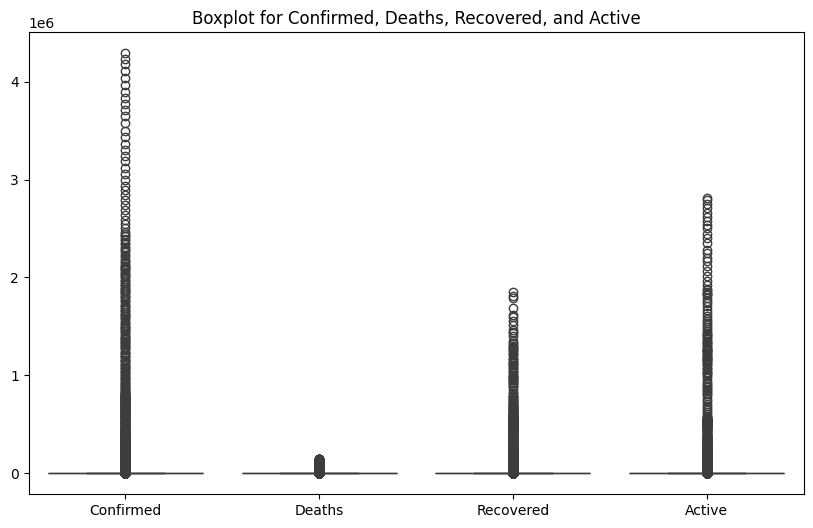

In [10]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=covid_19_clean_complete[['Confirmed', 'Deaths', 'Recovered', 'Active']])

plt.title('Boxplot for Confirmed, Deaths, Recovered, and Active')

plt.show()

# Statistical Detection of Outliers using IQR

In [11]:
def identify_outliers(df, column):

    Q1 = df[column].quantile(0.25)

    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR

    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return outliers



outliers_confirmed = identify_outliers(covid_19_clean_complete, 'Confirmed')

outliers_deaths = identify_outliers(covid_19_clean_complete, 'Deaths')

outliers_recovered = identify_outliers(covid_19_clean_complete, 'Recovered')

outliers_active = identify_outliers(covid_19_clean_complete, 'Active')



print(f"outliers in Confirmed Cases: {outliers_confirmed.shape[0]}")

print(f"outliers in Deaths: {outliers_deaths.shape[0]}")

print(f"outliers in Recovered Cases: {outliers_recovered.shape[0]}")

print(f"outliers in Active Cases: {outliers_active.shape[0]}")

outliers in Confirmed Cases: 8817
outliers in Deaths: 9077
outliers in Recovered Cases: 7936
outliers in Active Cases: 8914


# Handling Outliers

In [12]:
def replace_outliers(df, column):

    Q1 = df[column].quantile(0.25)

    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR

    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].apply(lambda x: df[column].median() if x < lower_bound or x > upper_bound else x)

    return df



covid_19_clean_complete = replace_outliers(covid_19_clean_complete, 'Confirmed')

covid_19_clean_complete = replace_outliers(covid_19_clean_complete, 'Deaths')

covid_19_clean_complete = replace_outliers(covid_19_clean_complete, 'Recovered')

covid_19_clean_complete = replace_outliers(covid_19_clean_complete, 'Active')

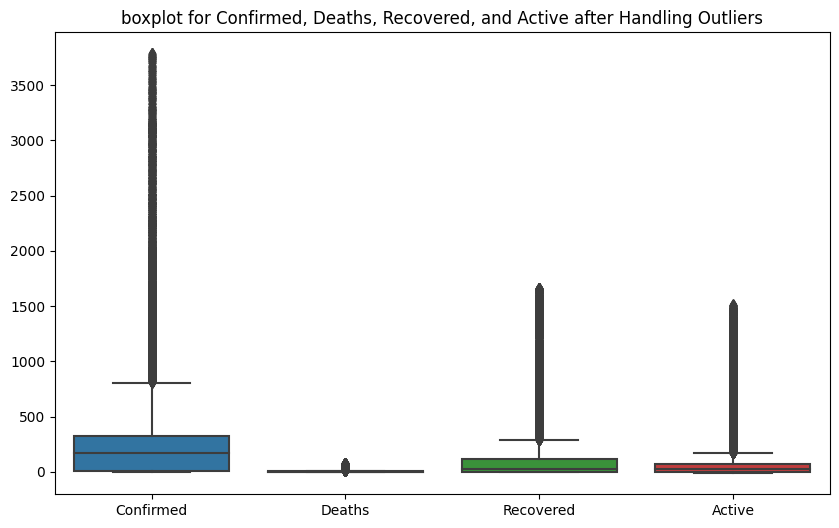

In [ ]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=covid_19_clean_complete[['Confirmed', 'Deaths', 'Recovered', 'Active']])

plt.title('boxplot for Confirmed, Deaths, Recovered, and Active after Handling Outliers')

plt.show()





---




# Saving datasets after handling

In [ ]:
covid_19_clean_complete.to_csv('cleaned_covid_19_clean_complete.csv', index=False)



usa_county_wise.to_csv('cleaned_usa_county_wise.csv', index=False)



worldometer_data.to_csv('cleaned_worldometer_data.csv', index=False)



country_wise_latest.to_csv('cleaned_country_wise_latest.csv', index=False)



print("Affected datasets have been saved as CSV files.")

Affected datasets have been saved as CSV files.






---




# **Visualization**

# visualizations to uncover patterns and trends:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


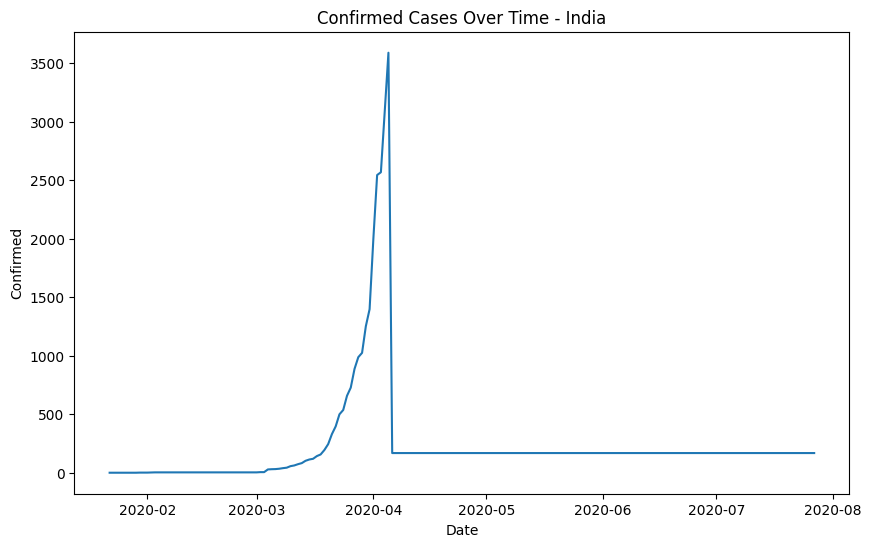

In [ ]:
# Confirmed cases over time for a india

plt.figure(figsize=(10, 6))

sns.lineplot(x='Date', y='Confirmed', data=covid_19_clean_complete[covid_19_clean_complete['Country/Region'] == 'India'])

plt.title('Confirmed Cases Over Time - India')

plt.show()

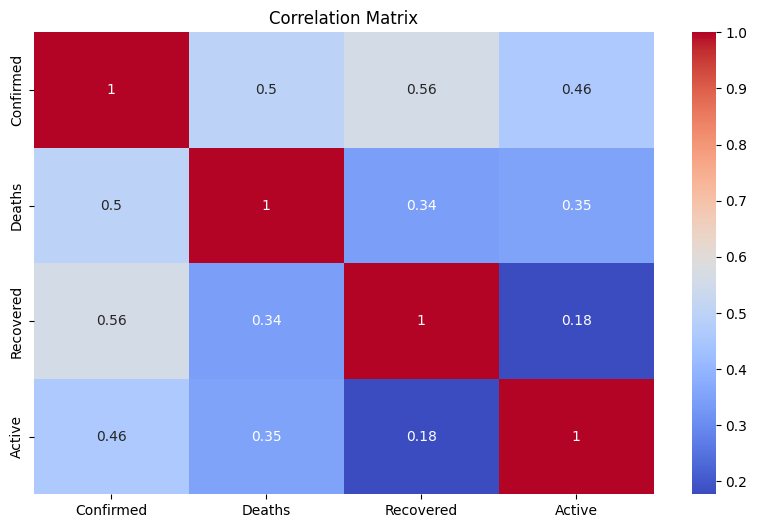

In [ ]:
plt.figure(figsize=(10, 6))

sns.heatmap(covid_19_clean_complete[['Confirmed', 'Deaths', 'Recovered', 'Active']].corr(), annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')

plt.show()





---


